In this notebook we will try to tune xgboost. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [2]:
cmm_pa_clf_read = pd.read_csv("Data/cmm_pa_clf.csv",index_col = 0)
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()
cmm_pa_clf_data_train,cmm_pa_clf_data_test,cmm_pa_clf_target_train,cmm_pa_clf_target_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

The following function can be used to tune xgboost. 

In [3]:
def xgboost_tune(max_depth :int, subsample :float, 
                 tree_method :str,eval_metric :str,n_estimators :int, 
                 eta:float, kf_n_splits :int) -> list:
    
    skf = StratifiedKFold(n_splits=kf_n_splits)
    xgb_clf = xgb.XGBClassifier(max_depth=max_depth,
                                subsample = subsample,
                                tree_method = tree_method,
                                eval_metric = eval_metric,
                                n_estimators=n_estimators,
                                eta =eta)

    roc_auc = [[0] * n_estimators] * kf_n_splits
    i = 0
    for train_index, test_index in skf.split(cmm_pa_clf_data_train,cmm_pa_clf_target_train):
        cmm_pa_clf_data_train_train, cmm_pa_clf_data_train_hold = cmm_pa_clf_data_train.iloc[train_index], cmm_pa_clf_data_train.iloc[test_index]
        cmm_pa_clf_target_train_train, cmm_pa_clf_target_train_hold = cmm_pa_clf_target_train.iloc[train_index], cmm_pa_clf_target_train.iloc[test_index]
        xgb_clf_clone = clone(xgb_clf)
        xgb_clf_clone.fit(cmm_pa_clf_data_train_train,cmm_pa_clf_target_train_train,
                          eval_set = [(cmm_pa_clf_data_train_hold,cmm_pa_clf_target_train_hold)],
                          verbose = False)
        roc_auc[i] = xgb_clf_clone.evals_result()['validation_0']['auc']
        i = i+1

    return roc_auc
    

In [4]:
roc_auc = xgboost_tune(max_depth = 1, subsample = 0.5, 
                 tree_method = 'approx',eval_metric = 'auc',n_estimators = 50, eta = 0.2, kf_n_splits = 7)

/Users/yilizhang/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


preivously this box is used to test the function defined above. 


skf = StratifiedKFold(n_splits=7)
xgb_clf = xgb.XGBClassifier(
                            max_depth=1,
                            subsample = 0.5,
                            tree_method = 'approx',
                            eval_metric = 'auc',
                            n_estimators=50,
                            eta =.2)

roc_auc = [[0] * 50] * 7
i = 0
for train_index, test_index in skf.split(cmm_pa_clf_data_train,cmm_pa_clf_target_train):
    cmm_pa_clf_data_train_train, cmm_pa_clf_data_train_hold = cmm_pa_clf_data_train.iloc[train_index], cmm_pa_clf_data_train.iloc[test_index]
    cmm_pa_clf_target_train_train, cmm_pa_clf_target_train_hold = cmm_pa_clf_target_train.iloc[train_index], cmm_pa_clf_target_train.iloc[test_index]
    xgb_clf_clone = clone(xgb_clf)
    xgb_clf_clone.fit(cmm_pa_clf_data_train_train,cmm_pa_clf_target_train_train,
                     eval_set = [(cmm_pa_clf_data_train_hold,cmm_pa_clf_target_train_hold)],
                     verbose = False)
    roc_auc[i] = xgb_clf_clone.evals_result()['validation_0']['auc']
    i = i+1

roc_auc = np.array(roc_auc)

In [5]:
vec = np.array(roc_auc).mean(0)
length = len(vec)
print('The optimal number of weak learner for this xgbooster is ', np.argmax(vec)+1, 
      'it achieve an roc_auc score of ',np.max(vec).round(6),'.')

The optimal number of weak learner for this xgbooster is  45 it achieve an roc_auc score of  0.874595 .


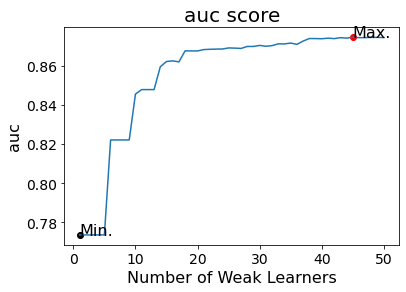

In [6]:
plt.plot(range(1,length+1), vec)
plt.scatter([range(1,length+1)[np.argmin(vec)]], 
            [np.min(vec)], c='k')
plt.scatter([range(1,length+1)[np.argmax(vec)]], 
            [np.max(vec)], c='r')
plt.text(range(1,length+1)[np.argmin(vec)], 
         np.min(vec), "Min.", fontsize=16)
plt.text(range(1,length+1)[np.argmax(vec)], 
         np.max(vec), "Max.", fontsize=16)

plt.title("auc score", fontsize=20)
plt.xlabel("Number of Weak Learners", fontsize=16)
plt.ylabel("auc", fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()